## **Data Preprocessing**

### Import the data

In [1]:
import pickle as pkl
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/train_X_2500k.pkl', 'rb') as f:
  input_texts = pkl.load(f)
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/train_Y_2500k.pkl', 'rb') as f:
  target_texts = pkl.load(f)

### Remove diacritics

In [2]:
import unicodedata

REMOVE_DIACRITIC_TABLE = str.maketrans(
    "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÍÌỈĨỊÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴáàảãạăắằẳẵặâấầẩẫậđèéẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ",
    "A" * 17 + "D" + "E" * 11 + "I" * 5 + "O" * 17 + "U" * 11 + "Y" * 5 + "a" * 17 + "d" + "e" * 11 + "i" * 5 + "o" * 17 + "u" * 11 + "y" * 5
)


def remove_diacritic(txt: str) -> str:
    if not unicodedata.is_normalized("NFC", txt):
        txt = unicodedata.normalize("NFC", txt)
    return txt.translate(REMOVE_DIACRITIC_TABLE)

print(remove_diacritic("Đà Nẵng?").lower())

da nang?


In [3]:
# Lower the text from input and output
input_temp = []
target_temp = []
for index in range(len(input_texts)):
  if len(input_texts[index].split()) < 100:
    input_temp.append(input_texts[index])
    target_temp.append(target_texts[index])

input_texts = input_temp
target_texts = target_temp

### Tokenize

In [4]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [5]:
# Tokenize the inputs
MAX_NUM_WORDS = 100000
tokenizer_input = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_input.fit_on_texts(input_texts)
input_sequences = tokenizer_input.texts_to_sequences(input_texts)

### Get the mapping from input-to-index and padding sequences

In [6]:
# Get the word to index mapping for input
word2idx_input = tokenizer_input.word_index
print('Found %s unique tokens.' % len(word2idx_input))

Found 97115 unique tokens.


In [7]:
# determine max length input sequence
max_len_input = max(len(s) for s in input_sequences)
print('Max input length:', max_len_input)

Max input length: 118


In [8]:
# pad the sequences to NxT matrix
input_sequences = pad_sequences(input_sequences, maxlen=max_len_input, padding='post', value=0)
print('Shape of input tensor:', input_sequences.shape)
# [1, 2, 1, 3, 0, 0] max_len_input = 6

Shape of input tensor: (2489849, 118)


In [9]:
# Create a mapping from targets to target labels
import re
def remove_punctuation(text: str) -> str:
    return re.sub(r'[^\w\s]', '', text)

In [10]:
target_texts = [remove_punctuation(txt) for txt in target_texts]

In [11]:
print(len(input_texts))
print(len(target_texts))

2489849
2489849


### Word to Index Dictionary

In [12]:
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/all-vietnamese-syllables.txt', 'r', encoding='utf-8') as f:
  all_syllables = f.read().split('\n')

In [13]:
word2idx = {}
for text in target_texts:
  data = text.split(' ')
  for word in data:
    remove_diacritic_word = remove_diacritic(word)
    if remove_diacritic_word not in word2idx:
      word2idx[remove_diacritic_word] = {word: 1}
    else:
      if word not in word2idx[remove_diacritic_word]:
        word2idx[remove_diacritic_word][word] = len(word2idx[remove_diacritic_word]) + 1

In [14]:
for word in all_syllables:
  remove_diacritic_word = remove_diacritic(word)
  if remove_diacritic_word not in word2idx:
    word2idx[remove_diacritic_word] = {word: 1}
  else:
    if word not in word2idx[remove_diacritic_word]:
      word2idx[remove_diacritic_word][word] = len(word2idx[remove_diacritic_word]) + 1

In [15]:
len(word2idx)

152233

### Padding the target sequences

In [16]:
target_labels = []
for text in target_texts:
  label = []
  data = text.split(' ')
  for word in data:
    remove_diacritic_word = remove_diacritic(word)
    label.append(word2idx[remove_diacritic_word][word])
  target_labels.append(label)

In [17]:
target_labels = pad_sequences(target_labels, maxlen=max_len_input, padding='post', value=0)
print('Shape of target tensor:', target_labels.shape)

Shape of target tensor: (2489849, 118)


In [18]:
num_labels = max(max(label) for label in target_labels) + 1

In [19]:
num_labels

37

### Create an index-to-word Dictionary

In [20]:
idx2word = {}
for key in word2idx.keys():
  idx2word[key] = {}
  for word in word2idx[key].keys():
    idx2word[key][word2idx[key][word]] = word

## **Deploy the model**

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [22]:
num_words = min(MAX_NUM_WORDS, len(word2idx_input) + 1)

### Positional Encoding

In [23]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [24]:
@tf.keras.saving.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Base Attention Layer

In [25]:
@tf.keras.saving.register_keras_serializable()
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-7)
    self.add = tf.keras.layers.Add()

In [26]:
# Global attention layer
@tf.keras.saving.register_keras_serializable()
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


### FeedForward Network

In [27]:
@tf.keras.saving.register_keras_serializable()
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-7)

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

### Encoder Layer

In [28]:
@tf.keras.saving.register_keras_serializable()
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

### **Encoder**

In [29]:
@tf.keras.saving.register_keras_serializable()
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

## **Get the model**

In [30]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, TimeDistributed

In [31]:
EMBEDDING_DIM = 100
NUM_LAYERS = 4
VOCAB_SIZE = len(word2idx_input)
NUM_HEADS = 8
MAX_LENGTH_INPUT = max_len_input

In [32]:
# Instantiate the encoder.
encoder = Encoder(num_layers=NUM_LAYERS,
                  d_model=EMBEDDING_DIM,
                  num_heads=NUM_HEADS,
                  dff=MAX_LENGTH_INPUT,
                  vocab_size=VOCAB_SIZE)

In [33]:
input = Input(shape=(max_len_input,))
x = encoder(input)
out = TimeDistributed(Dense(num_labels, activation="softmax"))(x)
model = Model(input, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 118)]             0         
                                                                 
 encoder (Encoder)           (None, 118, 100)          11098372  
                                                                 
 time_distributed (TimeDist  (None, 118, 37)           3737      
 ributed)                                                        
                                                                 
Total params: 11102109 (42.35 MB)
Trainable params: 11102109 (42.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Train the model**

In [34]:
import keras.backend as K

In [35]:
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

In [69]:
@tf.keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

In [70]:
learning_rate = CustomSchedule(d_model=EMBEDDING_DIM)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

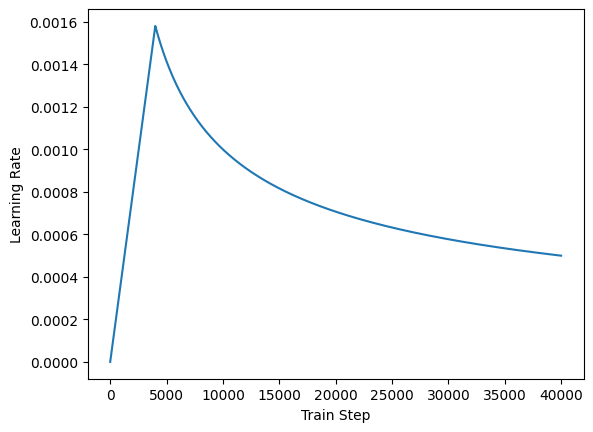

In [71]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [72]:
def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.cast(y_true, dtype='int64')
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

In [73]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=1.5*1e-2,
                                            patience=1)

In [74]:
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=[acc]
              )

In [42]:
print('Training model...')
r = model.fit(
    input_sequences,
    target_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[callback]
)

Training model...
Epoch 1/10
15562/15562 [==============================] - 774s 49ms/step - loss: 0.6427 - acc: 0.7977 - val_loss: 0.4922 - val_acc: 0.8506
Epoch 2/10
15562/15562 [==============================] - 738s 47ms/step - loss: 0.4832 - acc: 0.8499 - val_loss: 0.4493 - val_acc: 0.8634
Epoch 3/10
15562/15562 [==============================] - 736s 47ms/step - loss: 0.4524 - acc: 0.8596 - val_loss: 0.4296 - val_acc: 0.8700
Epoch 4/10
15562/15562 [==============================] - 733s 47ms/step - loss: 0.4358 - acc: 0.8648 - val_loss: 0.4214 - val_acc: 0.8730


In [43]:
import matplotlib.pyplot as plt

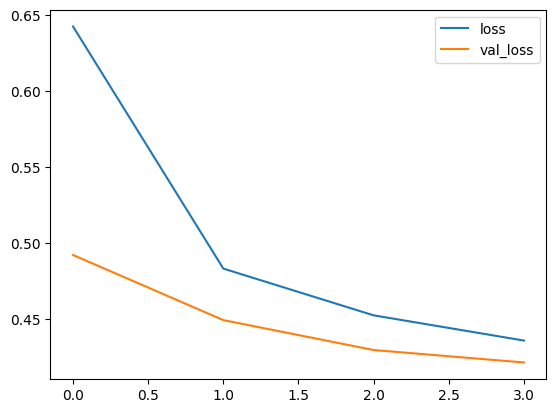

In [44]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

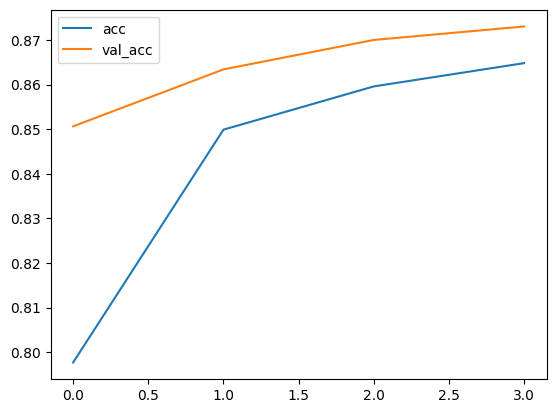

In [45]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## **Prediction Phase**

In [46]:
import numpy as np

In [47]:
def convert_text_to_sequences(text):
  text_sequences = tokenizer_input.texts_to_sequences(text)
  text_sequences = pad_sequences(text_sequences, maxlen=max_len_input, padding='post', value=0)
  return text_sequences

In [59]:
def get_prediction(list_of_queries: list):
  text_queries = convert_text_to_sequences(list_of_queries)
  p = model.predict(text_queries)
  p = np.argmax(p, axis=-1)
  predict_output = []
  for query in list_of_queries:
     user_query_split = remove_punctuation(query).lower().split(" ")
     predict_output_temp = ""
     for t in range(len(user_query_split)):
       if user_query_split[t] not in idx2word.keys() or p[0][t] not in idx2word[user_query_split[t]].keys():
         predict_output_temp += user_query_split[t] + " "
       else:
        predict_output_temp += str(idx2word[user_query_split[t]][p[0][t]]) + " "
     predict_output.append(predict_output_temp)
  return predict_output

In [49]:
user_query = [input_texts[3000]]

In [50]:
print(get_prediction(user_query))
print(target_texts[3000])

1/1 [==============================] - 1s 683ms/step
[' là nhưng quật thạo mọi lẫn ánh bực đốc điều gì em cũng chẳng hệ hãy biết ']
 là những quát tháo mỗi lần anh bực dọc điều gì em cũng chẳng hề hay biết


In [51]:
print(get_prediction(["Hom nay troi dep, troi trong xanh bao la"]))

1/1 [==============================] - 0s 24ms/step
['hôm nay trời đẹp trời trong xanh bao la ']


## **Test Phase**

In [52]:
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/test_X_250k.pkl', 'rb') as f:
  input_test_texts = pkl.load(f)
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/test_Y_250k.pkl', 'rb') as f:
  target_test_texts = pkl.load(f)

In [53]:
indexes = [i for i in range(10)]

In [60]:
for index in indexes:
  print("Predict: " + get_prediction([input_test_texts[index]])[0])
  print("Actual: " + target_test_texts[index])

1/1 [==============================] - 0s 29ms/step
Predict:  cực bvtv khuyên cao su đứng nhưng thuốc cô hoắt chát hexaconazole saizole 5sc nằm trong nhóm này hoặc hỗn hợp những thuốc có hoạt chất hexaconazole với thuốc có hoạt chát carbendazim carbenzim 500fl nằm trong nhóm này dễ phun xít 
Actual: - Cục BVTV khuyến cáo sử dụng những thuốc có hoạt chất Hexaconazole (Saizole 5SC nằm trong nhóm này), hoặc hỗn hợp những thuốc có hoạt chất Hexaconazole với thuốc có hoạt chất Carbendazim (Carbenzim 500FL nằm trong nhóm này) để phun xịt.
1/1 [==============================] - 0s 25ms/step
Predict: khi sử dụng thuốc bà con cần lưu ý  phai phùn ướt đểu mắt đuổi cứa là 
Actual: Khi sử dụng thuốc bà con cần lưu ý: - Phải phun ướt đều mặt dưới của lá.
1/1 [==============================] - 0s 25ms/step
Predict: nếu nặng phải phun vài lần cách nhau 710 ngày cho đến khi bệnh ngừng phát triển 
Actual: Nếu nặng phải phun vài lần, cách nhau 7-10 ngày, cho đến khi bệnh ngưng phát triển.
1/1 [=========

In [61]:
word2idx['lam']

{'làm': 1,
 'lắm': 2,
 'lầm': 3,
 'lấm': 4,
 'lâm': 5,
 'lam': 6,
 'lăm': 7,
 'lẩm': 8,
 'lạm': 9,
 'lẫm': 10,
 'lãm': 11,
 'lảm': 12,
 'lậm': 13,
 'lám': 14,
 'lằm': 15,
 'lẳm': 16,
 'lẵm': 17,
 'lặm': 18}

## **Save and Load the Model**

In [92]:
# serialize model to JSON
model_json = model.to_json()
with open("transformer.json", "w") as json_file:
    json_file.write(model_json)

In [93]:
# serialize weights to HDF5
model.save_weights("transformer_weights.h5")
print("Saved model to disk")

Saved model to disk


In [94]:
# load json and create model
json_file = open('transformer.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [95]:
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("transformer_weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [96]:
loaded_model.predict(convert_text_to_sequences(["Hom nay troi dep, troi trong xanh bao la"]))

1/1 [==============================] - 1s 663ms/step


array([[[4.1954212e-05, 9.9703670e-01, 7.0733664e-04, ...,
         3.9014558e-14, 4.5882962e-14, 4.0421273e-14],
        [4.7433252e-05, 9.8889577e-01, 5.1279408e-03, ...,
         1.0168564e-14, 8.3536541e-15, 7.9034103e-15],
        [1.4856822e-04, 7.0713973e-01, 2.4093349e-01, ...,
         9.3589456e-14, 7.6881860e-14, 8.1473687e-14],
        ...,
        [3.8466189e-02, 7.9661745e-01, 3.5718262e-02, ...,
         8.1161006e-10, 9.5979702e-10, 9.7514963e-10],
        [3.8362682e-02, 7.9533935e-01, 3.6467139e-02, ...,
         8.0892437e-10, 9.5291675e-10, 9.7064445e-10],
        [3.8410153e-02, 7.9470867e-01, 3.7272420e-02, ...,
         7.9018569e-10, 9.2862962e-10, 9.4601360e-10]]], dtype=float32)

In [85]:
import pickle

In [86]:
# save the model to disk
filename = 'tokenizer.pickle'
pickle.dump(tokenizer_input, open(filename, 'wb'))

In [87]:
# load the model from disk
loaded_tokenizer = pickle.load(open(filename, 'rb'))

In [88]:
loaded_tokenizer.texts_to_sequences(["Hom nay troi dep, troi trong xanh bao la"])

[[408, 29, 441, 343, 441, 10, 484, 70, 3]]

In [89]:
import json

In [91]:
# Convert and write JSON object to file
with open("index_to_word.json", "w") as outfile:
    json.dump(idx2word, outfile)